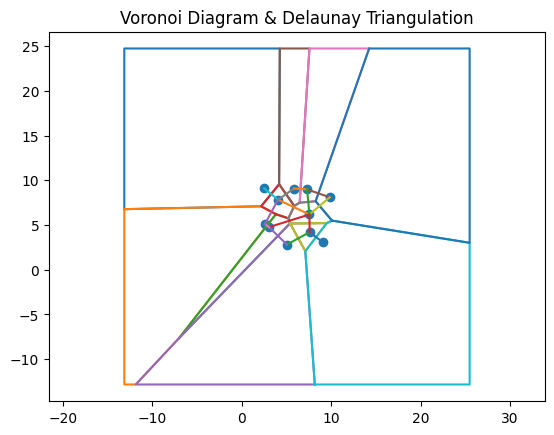

In [61]:
import random
import matplotlib.pyplot as plt
from collections import namedtuple

# --- Voronoi / Delaunay implementation (divide & conquer) ---
Point = namedtuple("Point", ["x", "y"])

def bisector(p, q):
    mx = (p.x + q.x) / 2
    my = (p.y + q.y) / 2
    dx = q.x - p.x
    dy = q.y - p.y
    a, b = dx, dy
    c = -(a * mx + b * my)
    sign_p = a * p.x + b * p.y + c
    keep_positive = sign_p >= 0
    return a, b, c, keep_positive

def clip_polygon(poly, a, b, c, keep_positive=True):
    new_poly = []
    n = len(poly)
    for i in range(n):
        p1, p2 = poly[i], poly[(i + 1) % n]
        v1, v2 = a * p1.x + b * p1.y + c, a * p2.x + b * p2.y + c
        inside1 = (v1 >= 0) if keep_positive else (v1 <= 0)
        inside2 = (v2 >= 0) if keep_positive else (v2 <= 0)
        if inside1 and inside2:
            new_poly.append(p2)
        elif inside1 and not inside2:
            t = v1 / (v1 - v2)
            new_poly.append(Point(p1.x + t * (p2.x - p1.x), p1.y + t * (p2.y - p1.y)))
        elif not inside1 and inside2:
            t = v1 / (v1 - v2)
            new_poly.append(Point(p1.x + t * (p2.x - p1.x), p1.y + t * (p2.y - p1.y)))
            new_poly.append(p2)
    return new_poly

def voronoi_dc(points, bbox):
    if len(points) == 1:
        xmn, xmx, ymn, ymx = bbox
        return {points[0]: [Point(xmn, ymn), Point(xmx, ymn), Point(xmx, ymx), Point(xmn, ymx)]}
    if len(points) == 2:
        p, q = points
        xmn, xmx, ymn, ymx = bbox
        init = [Point(xmn, ymn), Point(xmx, ymn), Point(xmx, ymx), Point(xmn, ymx)]
        a, b, c, kp = bisector(p, q)
        return {
            p: clip_polygon(init, a, b, c, keep_positive=kp),
            q: clip_polygon(init, a, b, c, keep_positive=not kp)
        }
    points = sorted(points, key=lambda p: p.x)
    mid = len(points) // 2
    left, right = points[:mid], points[mid:]
    vor_l = voronoi_dc(left, bbox)
    vor_r = voronoi_dc(right, bbox)
    vor = {**vor_l, **vor_r}
    for p in left:
        cell = vor[p]
        for q in right:
            a, b, c, kp = bisector(p, q)
            cell = clip_polygon(cell, a, b, c, keep_positive=kp)
        vor[p] = cell
    for q in right:
        cell = vor[q]
        for p in left:
            a, b, c, kq = bisector(q, p)
            cell = clip_polygon(cell, a, b, c, keep_positive=kq)
        vor[q] = cell
    return vor

def compute_bbox(points, factor=2):
    xs, ys = [p.x for p in points], [p.y for p in points]
    dx, dy = max(xs) - min(xs), max(ys) - min(ys)
    m = max(dx, dy) * factor + 1
    return [min(xs)-m, max(xs)+m, min(ys)-m, max(ys)+m]

def compute_voronoi(points):
    return voronoi_dc(points, compute_bbox(points))

def on_edge(pt, poly, tol=1e-6):
    for i in range(len(poly)):
        a, b = poly[i], poly[(i+1)%len(poly)]
        area = abs((b.x-a.x)*(pt.y-a.y) - (b.y-a.y)*(pt.x-a.x))
        if area < tol:
            dot = (pt.x-a.x)*(pt.x-b.x) + (pt.y-a.y)*(pt.y-b.y)
            if dot <= tol:
                return True
    return False

def compute_delaunay(vor):
    edges = set()
    sites = list(vor.keys())
    for i, p in enumerate(sites):
        for q in sites[i+1:]:
            mid = Point((p.x+q.x)/2, (p.y+q.y)/2)
            if on_edge(mid, vor[p]) and on_edge(mid, vor[q]):
                edges.add((p, q))
    return list(edges)

# --- Generate random points and compute diagrams ---
random.seed(0)
n = random.randint(5, 15)
points = [Point(random.uniform(0, 10), random.uniform(0, 10)) for _ in range(n)]
vor = compute_voronoi(points)
delaunay = compute_delaunay(vor)

# --- Plotting ---
plt.figure()
# Voronoi cells
for cell in vor.values():
    xs = [p.x for p in cell] + [cell[0].x]
    ys = [p.y for p in cell] + [cell[0].y]
    plt.plot(xs, ys)

# Delaunay edges
for p, q in delaunay:
    plt.plot([p.x, q.x], [p.y, q.y])

# Points
plt.scatter([p.x for p in points], [p.y for p in points])

plt.axis("equal")
plt.title("Voronoi Diagram & Delaunay Triangulation")
plt.show()


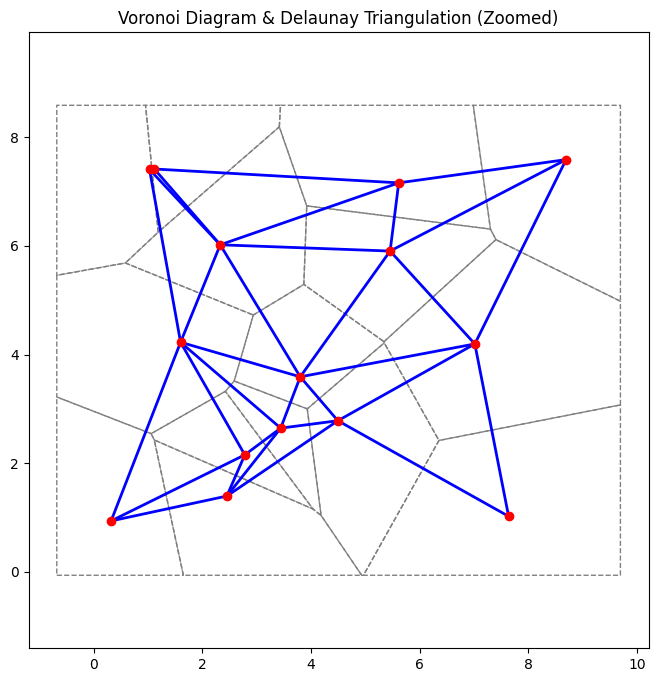

In [ ]:
import random
import matplotlib.pyplot as plt
from collections import namedtuple

Point = namedtuple("Point", ["x", "y"])


# --------------------------------------------------------------------------------------------------
# 2) Поиск бисектора (перпендикулярного делителя) между двумя точками p и q
#
#    - Сначала вычисляем середину отрезка (mx, my).
#    - Вектор между точками (dx, dy) является нормалью к биссектрисе.
#    - Уравнение прямой: a·x + b·y + c = 0, где (a, b) = (dx, dy), а c подбираем так, чтобы
#      прямая проходила через (mx, my).
#    - Затем определяем, с какой стороны прямой лежит точка p (для обрезки): keep_positive=True,
#      если выражение a·p.x + b·p.y + c ≥ 0.
# --------------------------------------------------------------------------------------------------
def bisector(p, q):
    mx, my = (p.x + q.x) / 2, (p.y + q.y) / 2       # координаты середины отрезка
    dx, dy = q.x - p.x, q.y - p.y                   # вектор от p к q → нормаль к биссектрисе
    a, b = dx, dy
    c = -(a * mx + b * my)                          # подбор c для прохождения через (mx, my)
    sign_p = a * p.x + b * p.y + c                  # знак выражения в точке p
    keep_positive = (sign_p >= 0)                   # будем сохранять ту полуплоскость, где точка p
    return a, b, c, keep_positive


# --------------------------------------------------------------------------------------------------
# 3) Обрезка (клинг) одного многоугольника отрезком-прямой через полуплоскость
#
#    Аргументы:
#      poly           исходный многоугольник списка точек [P0, P1, …]
#      (a, b, c)      коэффициенты прямой a·x + b·y + c = 0
#      keep_positive  True → сохраняем ту часть, где a·x + b·y + c ≥ 0
#
#    Алгоритм:
#      - Поочерёдно проходим по каждому ребру (P_i → P_{i+1}).
#      - Определяем, находятся ли концы ребра "inside" (внутри нужной полуплоскости).
#      - В зависимости от четырёх случаев (in–in, in–out, out–in, out–out) добавляем в новый
#        полигон либо вторую вершину, либо точку пересечения, либо и то, и другое.
# --------------------------------------------------------------------------------------------------
def clip_polygon(poly, a, b, c, keep_positive=True):
    new_poly = []
    n = len(poly)
    for i in range(n):
        p1, p2 = poly[i], poly[(i + 1) % n]
        v1 = a * p1.x + b * p1.y + c
        v2 = a * p2.x + b * p2.y + c
        inside1 = (v1 >= 0) if keep_positive else (v1 <= 0)
        inside2 = (v2 >= 0) if keep_positive else (v2 <= 0)

        # Оба конца в нужной полуплоскости → добавляем вторую вершину
        if inside1 and inside2:
            new_poly.append(p2)

        # Выход из области → находим точку пересечения и добавляем её
        elif inside1 and not inside2:
            t = v1 / (v1 - v2)
            new_poly.append(Point(
                p1.x + t * (p2.x - p1.x),
                p1.y + t * (p2.y - p1.y)
            ))

        # Вход в область → сначала точка пересечения, потом вторая вершина
        elif not inside1 and inside2:
            t = v1 / (v1 - v2)
            new_poly.append(Point(
                p1.x + t * (p2.x - p1.x),
                p1.y + t * (p2.y - p1.y)
            ))
            new_poly.append(p2)

        # if both outside → ничего не добавляем

    return new_poly


# --------------------------------------------------------------------------------------------------
# 4) Рекурсивный алгоритм divide-and-conquer для построения диаграммы Вороного
#
#    Базовые случаи:
#      • 1 точка → вся область (bbox) является её ячейкой.
#      • 2 точки → просто две полуплоскости, разделяющие bbox.
#
#    Рекурсивный случай:
#      1) Сортируем точки по x и делим пополам на left/right.
#      2) Рекурсивно строим voronoi для left и для right.
#      3) «Merge»: для каждой точки из left обрезаем её ячейку биссектрисами относительно всех
#         точек из right, и наоборот.
# --------------------------------------------------------------------------------------------------
def voronoi_dc(points, bbox):
    # 4.1) Базовый случай: единичная точка
    if len(points) == 1:
        xmn, xmx, ymn, ymx = bbox
        # Ячейка = весь bbox
        return {points[0]: [
            Point(xmn, ymn), Point(xmx, ymn),
            Point(xmx, ymx), Point(xmn, ymx)
        ]}

    # 4.2) Базовый случай: две точки
    if len(points) == 2:
        p, q = points
        xmn, xmx, ymn, ymx = bbox
        init = [Point(xmn, ymn), Point(xmx, ymn),
                Point(xmx, ymx), Point(xmn, ymx)]
        # Получаем биссектрису и две полупространства
        a, b, c, kp = bisector(p, q)
        # Обрезаем bbox → получаем две ячейки
        return {
            p: clip_polygon(init, a, b, c, keep_positive=kp),
            q: clip_polygon(init, a, b, c, keep_positive=(not kp))
        }

    # 4.3) Рекурсивная часть
    pts_sorted = sorted(points, key=lambda p: p.x)
    mid = len(pts_sorted) // 2
    left, right = pts_sorted[:mid], pts_sorted[mid:]

    # Строим поддиаграммы
    vor_left = voronoi_dc(left, bbox)
    vor_right = voronoi_dc(right, bbox)

    # Объединяем словари ячеек
    vor = {**vor_left, **vor_right}

    # Для точек из left «отрезаем» влиянием right
    for p in left:
        cell = vor[p]
        for q in right:
            a, b, c, kp = bisector(p, q)
            cell = clip_polygon(cell, a, b, c, keep_positive=kp)
        vor[p] = cell

    # Аналогично для точек из right
    for q in right:
        cell = vor[q]
        for p in left:
            a, b, c, kq = bisector(q, p)
            cell = clip_polygon(cell, a, b, c, keep_positive=kq)
        vor[q] = cell

    return vor


# --------------------------------------------------------------------------------------------------
# 5) Вычисление ограничивающего прямоугольника (bbox) для всех точек с небольшим отступом
#    factor=0 → отступ = 1
# --------------------------------------------------------------------------------------------------
def compute_bbox(points, factor=0):
    xs = [p.x for p in points]
    ys = [p.y for p in points]
    dx, dy = max(xs) - min(xs), max(ys) - min(ys)
    margin = max(dx, dy) * factor + 1
    return [
        min(xs) - margin, max(xs) + margin,
        min(ys) - margin, max(ys) + margin
    ]


# Удобная обёртка для построения диаграммы
def compute_voronoi(points):
    bbox = compute_bbox(points, factor=0)
    return voronoi_dc(points, bbox)


# --------------------------------------------------------------------------------------------------
# 6) Построение триангуляции Делоне как двойственного графа диаграммы Вороного
#
#    Алгоритм:
#      • Для каждой ячейки собираем её ребра в виде упорядоченных пар концов (edge_map).
#      • Две сайты-соседа в делоне, ↔ их ячейки в Вороного имеют общий отрез:
#        если их множества ребер пересекаются → добавляем ребро (p, q).
# --------------------------------------------------------------------------------------------------
def compute_delaunay_from_voronoi(vor):
    # 6.1) Собираем все отрезы (грани) каждой ячейки
    edge_map = {}
    for site, poly in vor.items():
        segs = set()
        n = len(poly)
        for i in range(n):
            a_pt, b_pt = poly[i], poly[(i + 1) % n]
            # Округляем координаты, чтобы избежать проблем с плавающей точкой
            key = tuple(sorted([
                (round(a_pt.x, 6), round(a_pt.y, 6)),
                (round(b_pt.x, 6), round(b_pt.y, 6))
            ]))
            segs.add(key)
        edge_map[site] = segs

    # 6.2) Для каждой пары сайтов p, q проверяем наличие общей грани
    edges = set()
    sites = list(vor.keys())
    for i, p in enumerate(sites):
        for q in sites[i + 1:]:
            if edge_map[p].intersection(edge_map[q]):
                edges.add((p, q))

    return list(edges)


random.seed(42)
n = random.randint(7, 15)
points = [Point(random.uniform(0, 10), random.uniform(0, 10))
          for _ in range(n)]

vor = compute_voronoi(points)
delaunay_edges = compute_delaunay_from_voronoi(vor)

plt.figure(figsize=(8, 8))

for poly in vor.values():
    xs = [pt.x for pt in poly] + [poly[0].x]
    ys = [pt.y for pt in poly] + [poly[0].y]
    plt.plot(xs, ys, linestyle="--", linewidth=1, color="gray")

for p, q in delaunay_edges:
    plt.plot([p.x, q.x], [p.y, q.y], linewidth=2, color="blue")

plt.scatter(
    [pt.x for pt in points],
    [pt.y for pt in points],
    color="red",
    zorder=5
)

xs = [p.x for p in points]
ys = [p.y for p in points]
margin = 1.0
plt.xlim(min(xs) - margin, max(xs) + margin)
plt.ylim(min(ys) - margin, max(ys) + margin)

plt.title("Voronoi Diagram & Delaunay Triangulation")
plt.axis("equal")
plt.show()
